In [1]:
library("tidyverse")
library("zoo")
library("tidyr")
library("dplyr")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
base_url <- "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/"
access_type <- "?accessType=DOWNLOAD"
confirmed_filename <- "csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_filename <- "csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_filename <- "csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
regions_filename <- "UID_ISO_FIPS_LookUp_Table.csv"

In [3]:
cases <- read_csv(paste(base_url,confirmed_filename,access_type,sep=""))
deaths <- read_csv(paste(base_url,deaths_filename,access_type,sep=""))
regions <- read_csv(paste(base_url,regions_filename,access_type,sep=""))

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  UID = col_double(),
  iso2 = col_character(),
  iso3 = col_character(),
  code3 = col_double(),
  FIPS = col_character(),
  Admin2 = col_character(),
  Province_State = col_character(),
  Country_Region = col_character(),
  Lat = col_double(),
  Long_ = col_double(),
  Combined_Key = col_character(),
  Population = col_double()
)


In [4]:
colnames(cases)[colnames(cases) == "Country/Region"] <- "Country"
colnames(deaths)[colnames(deaths) == "Country/Region"] <- "Country"
colnames(regions)[colnames(regions) == "Country_Region"] <- "Country"

In [5]:
cases <- cases %>% 
    filter(is.na(cases["Province/State"])) %>% 
    select(-c("Province/State","Lat","Long")) %>%
    gather("day","cases",-c("Country"))

In [6]:
deaths <- deaths %>% 
    filter(is.na(deaths["Province/State"])) %>% 
    select(-c("Province/State","Lat","Long")) %>%
    gather("day","deaths",-c("Country"))

In [7]:
summary <- merge(cases,deaths,by=c("Country","day"))

In [8]:
regions <- regions %>% filter(is.na(regions["Province_State"])) %>% select("Country","Population")

In [9]:
summary <- merge(summary,regions,by="Country", all.y = FALSE)

In [10]:
summary <- summary %>% filter(!is.na(summary['Population']))

In [11]:
summary$day <- as.Date(summary$day, format = "%m/%d/%y")

In [12]:
summary <- summary[order(summary["Country"], summary["day"]),]

In [13]:
summary_aux <- summary %>% select("Country","day","cases","deaths") %>% mutate(day = day+1)

In [14]:
colnames(summary_aux)[colnames(summary_aux) == "cases"] <- "cases_lag"
colnames(summary_aux)[colnames(summary_aux) == "deaths"] <- "deaths_lag"

In [15]:
summary <- merge(summary,summary_aux,by=c("Country","day"), all.y=FALSE)

In [16]:
summary['cases_day'] = summary['cases']-summary['cases_lag']
summary['deaths_day'] = summary['deaths']-summary['deaths_lag']

In [17]:
summary <- summary %>% select(-c("cases_lag","deaths_lag"))

In [18]:
summary['cases_per_million'] = 1000000*summary['cases']/summary['Population']
summary['deaths_per_million'] = 1000000*summary['deaths']/summary['Population']
summary['cases_day_per_million'] = 1000000*summary['cases_day']/summary['Population']
summary['deaths_day_per_million'] = 1000000*summary['deaths_day']/summary['Population']

In [19]:
global_summary <- summary %>% group_by(day) %>% summarize(cases=sum(cases),deaths = sum(deaths),
                                                         cases_day=sum(cases_day), deaths_day=sum(deaths_day))

In [20]:
global_summary["cases_day_wa"] = rollmean(global_summary["cases_day"],7,c(NA,NULL,NA))
global_summary["deaths_day_wa"] = rollmean(global_summary["deaths_day"],7,c(NA,NULL,NA))

In [21]:
global_summary["mortality_rate"] <- global_summary["deaths"]/global_summary["cases"]

Warning message:
“Transformation introduced infinite values in continuous y-axis”

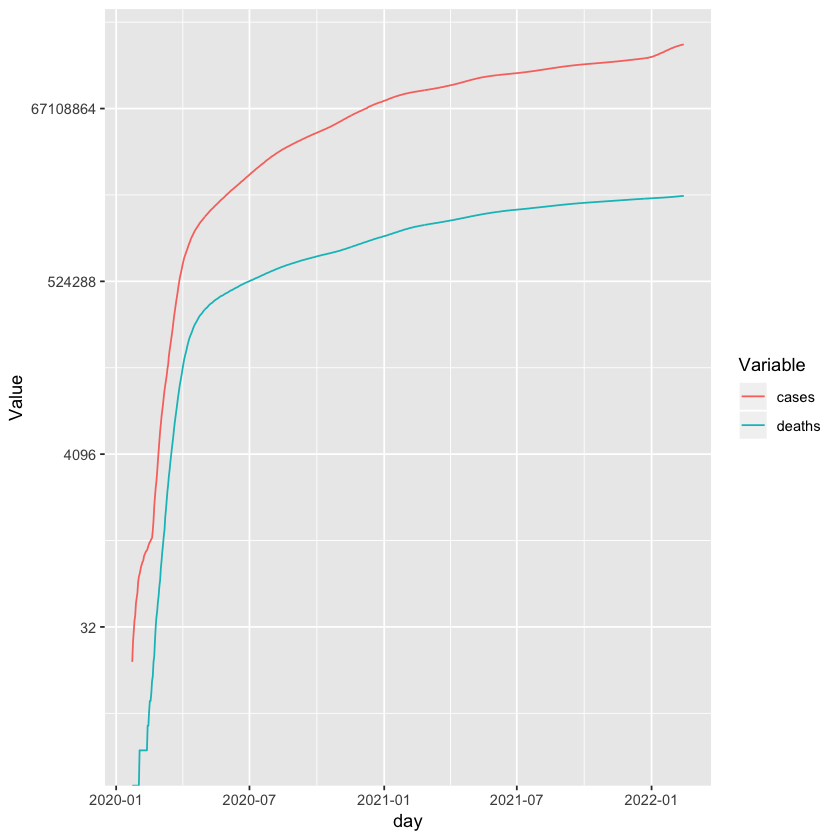

In [22]:
global_summary %>% select("day","cases","deaths") %>% gather("Variable","Value",-c("day")) %>% 
    ggplot(aes(x=day, y=Value,color=Variable)) + geom_line() + xlab("day") + scale_y_continuous(trans='log2')

Warning message:
“Removed 6 rows containing missing values (geom_path).”

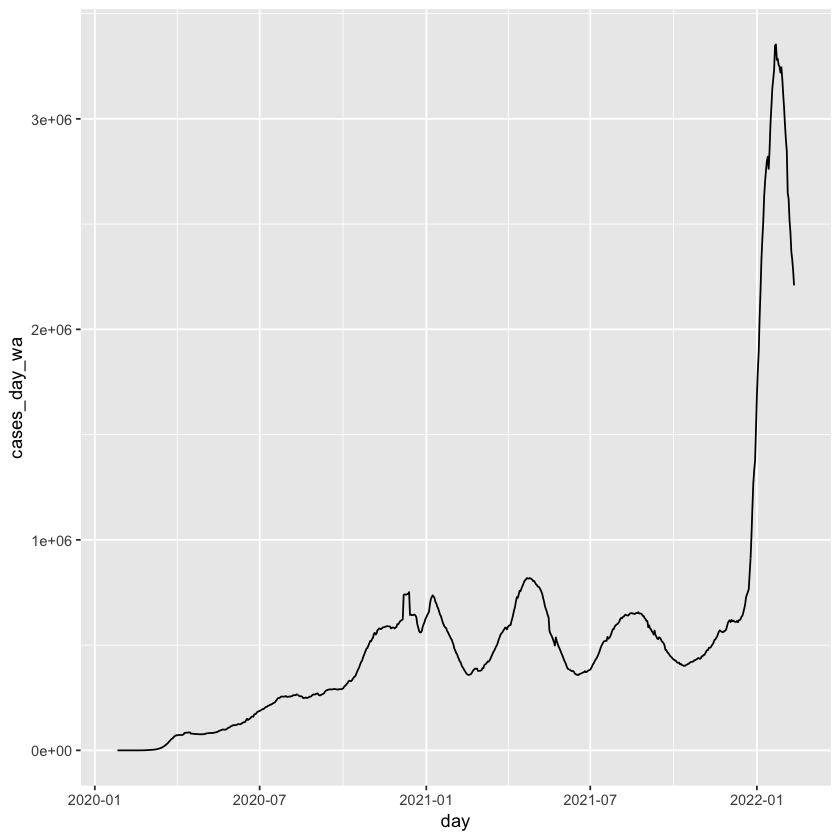

In [23]:
global_summary %>% select("day","cases_day_wa") %>% 
    ggplot(aes(x=day, y=cases_day_wa)) + geom_line() + xlab("day")

In [24]:
seq(0,1,0.1)

[1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

# global_summary

Warning message:
“Removed 6 rows containing missing values (geom_path).”

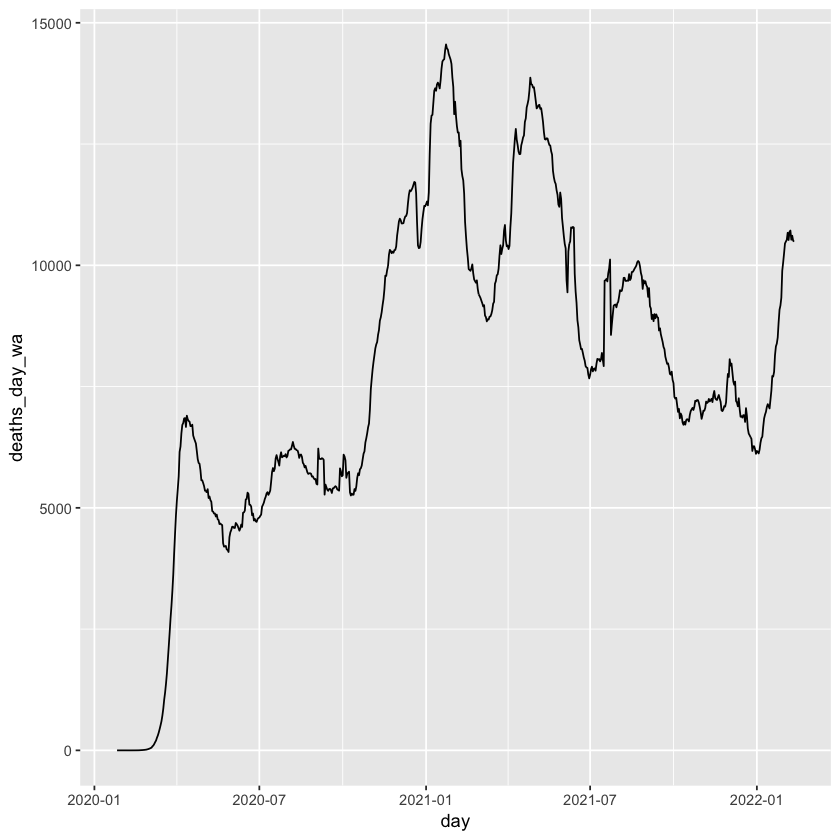

In [25]:
global_summary %>% select("day","deaths_day_wa") %>% 
    ggplot(aes(x=day, y=deaths_day_wa)) + geom_line() + xlab("day")

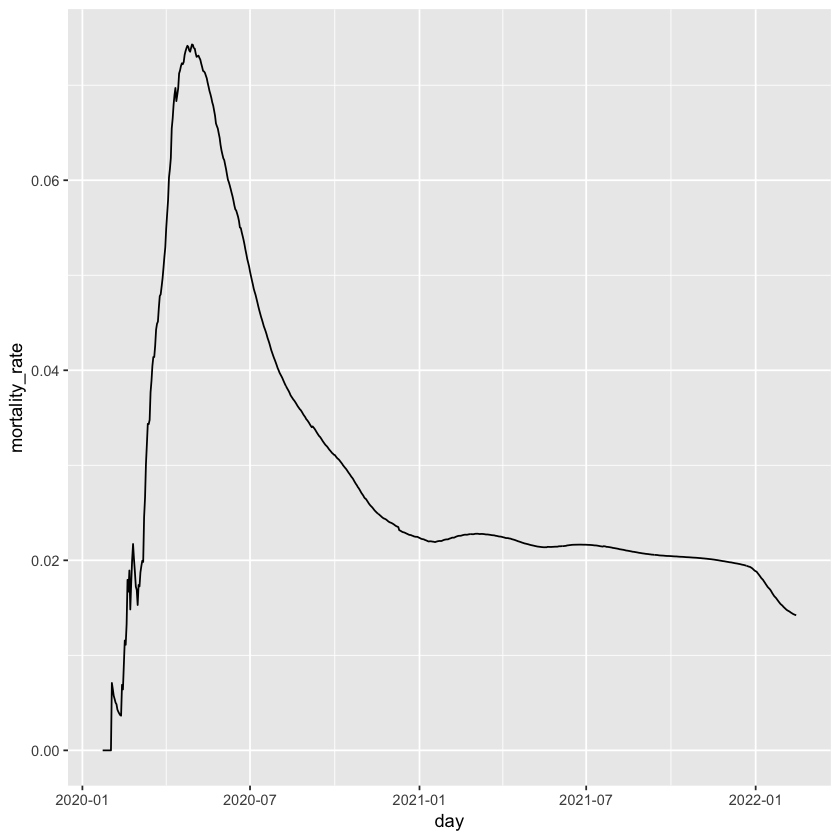

In [26]:
global_summary %>% select("day","mortality_rate") %>% 
    ggplot(aes(x=day, y=mortality_rate)) + geom_line() + xlab("day")

In [27]:
summary_total <- summary %>% group_by(Country) %>% summarize(cases=sum(cases_day), deaths=sum(deaths_day),
                                                     population=mean(Population))
summary_total["mortality_rate"] <- summary_total["deaths"]/summary_total["cases"]
summary_total["deaths_per_million"] <- 1000000*summary_total["deaths"]/summary_total["population"]
summary_total["cases_per_million"] <- 1000000*summary_total["cases"]/summary_total["population"]
summary_total_big <- summary_total %>% filter(population > 1000000)

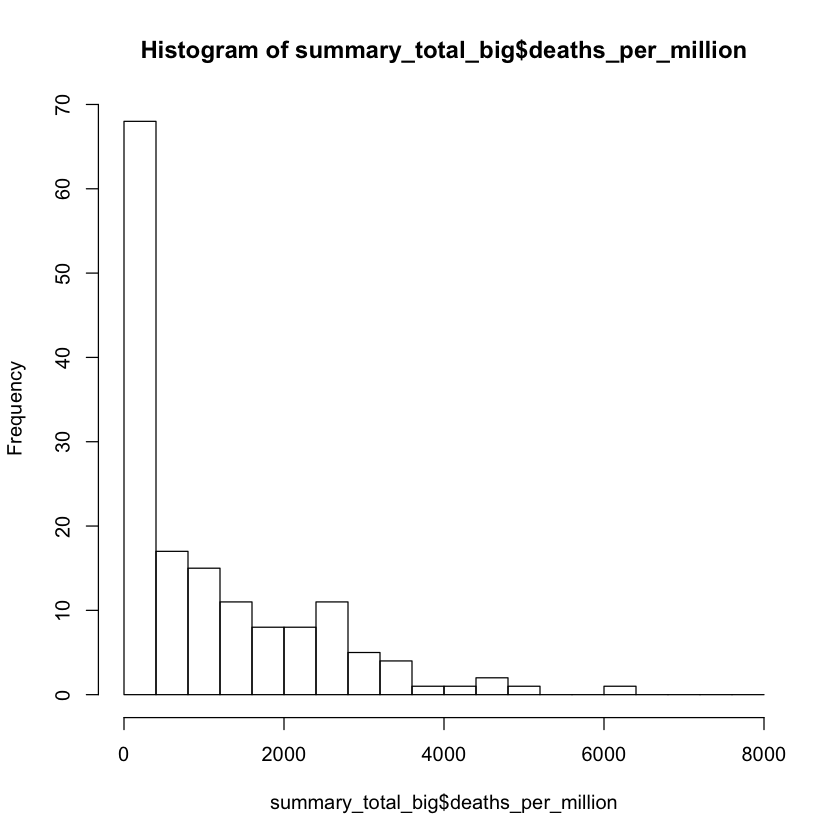

In [32]:
hist(summary_total_big$deaths_per_million,breaks=seq(0,8000,400))

In [70]:
head(summary_total_big[order(summary_total_big$deaths_per_million),],20)

Country,cases,deaths,population,mortality_rate,deaths_per_million,cases_per_million
Burundi,37902,38,11890781,0.001002586,3.195753,3187.5114
New Zealand,22328,53,4822233,0.002373701,10.990759,4630.2201
Chad,7216,190,16425859,0.026330377,11.567127,439.3073
South Sudan,16897,137,11193729,0.008107948,12.238996,1509.5059
Niger,8712,303,24206636,0.034779614,12.517229,359.9013
Tajikistan,17773,125,9537642,0.007033140,13.105965,1863.4585
Tanzania,33436,792,59734213,0.023687044,13.258733,559.7462
Benin,26552,163,12123198,0.006138897,13.445297,2190.1812
Congo (Kinshasa),85793,1316,89561404,0.015339247,14.693829,957.9238
Nigeria,254016,3141,206139587,0.012365363,15.237248,1232.2524


In [71]:
tail(summary_total_big[order(summary_total_big$deaths_per_million),],20)

Country,cases,deaths,population,mortality_rate,deaths_per_million,cases_per_million
Latvia,522766,5029,1886202,0.009619983,2666.204,277152.7
Colombia,6023257,137301,50882884,0.022795142,2698.373,118374.9
Moldova,485563,10962,4033963,0.022575855,2717.427,120368.7
Argentina,8747601,124349,45195777,0.014215212,2751.341,193549.1
Armenia,407074,8186,2963234,0.020109366,2762.522,137374.9
US,77919051,922473,329466283,0.011838863,2799.901,236500.8
Poland,5388907,108137,37846605,0.020066592,2857.244,142388.1
Slovenia,851416,6099,2078932,0.007163361,2933.718,409544.9
Lithuania,820131,8134,2722291,0.009917928,2987.925,301265.0
Brazil,27552267,639151,212559409,0.023197764,3006.929,129621.5


In [58]:
head(summary_total_big[order(summary_total_big$mortality_rate),],15)

Country,cases,deaths,population,mortality_rate,deaths_per_million,cases_per_million
Burundi,37902,38,11890781,0.001002586,3.195753,3187.511
Norway,1049811,1513,5421242,0.001441212,279.087338,193647.692
Denmark,2356873,4109,5837213,0.001743412,703.931825,403766.832
Qatar,351402,658,2881060,0.001872499,228.388163,121969.692
Singapore,478577,906,5850343,0.001893112,154.862715,81803.238
New Zealand,22328,53,4822233,0.002373701,10.990759,4630.220
Mongolia,885554,2148,3278292,0.002425600,655.219242,270126.639
United Arab Emirates,869428,2287,9890400,0.002630465,231.234328,87906.253
Cyprus,293040,788,1207361,0.002689053,652.663122,242711.169
Israel,3451526,9624,8655541,0.002788332,1111.888904,398764.907


In [52]:
tail(summary_total_big[order(summary_total_big$mortality_rate),],10)

Country,cases,deaths,population,mortality_rate,deaths_per_million,cases_per_million
Taiwan*,19620,851,23816775,0.04337411,35.73112,823.7891
Afghanistan,171246,7501,38928341,0.04380248,192.68738,4399.0059
Ecuador,799140,35036,17643060,0.04384213,1985.82332,45294.8638
Somalia,26203,1340,15893219,0.05113918,84.31269,1648.6906
Egypt,457081,23409,102334403,0.05121412,228.75005,4466.5429
Syria,52881,3032,17500657,0.05733628,173.25064,3021.6580
Mexico,5292706,312819,127792286,0.05910379,2447.87076,41416.4749
Peru,3449712,208466,32971846,0.06042997,6322.54560,104625.9891
Sudan,59903,3831,43849269,0.06395339,87.36748,1366.1117
Yemen,11679,2107,29825968,0.18040928,70.64314,391.5715


In [61]:
colnames(summary)

[1] "Country/Region"         "day"                    "cases"                 
 [4] "deaths"                 "Population"             "cases_day"             
 [7] "deaths_day"             "cases_per_million"      "deaths_per_million"    
[10] "cases_day_per_million"  "deaths_day_per_million"

In [28]:
regions

Country/Region,Population
Afghanistan,38928341
Albania,2877800
Antarctica,NA
Algeria,43851043
Andorra,77265
Angola,32866268
Antigua and Barbuda,97928
Argentina,45195777
Armenia,2963234
Austria,9006400


In [28]:
global_summary

day,cases,deaths,cases_day,deaths_day,cases_day_wa,deaths_day_wa
2020-01-23,12,0,3,0,NA,NA
2020-01-24,21,0,9,0,NA,NA
2020-01-25,28,0,7,0,NA,NA
2020-01-26,38,0,10,0,9.00000,0.0000000
2020-01-27,44,0,6,0,10.14286,0.0000000
2020-01-28,62,0,18,0,13.00000,0.0000000
2020-01-29,72,0,10,0,14.71429,0.0000000
2020-01-30,83,0,11,0,14.71429,0.1428571
2020-01-31,112,0,29,0,15.85714,0.1428571
2020-02-01,131,0,19,0,16.00000,0.1428571


In [ ]:
global_summary <- summary %>% group_by(day) %>% summarize(cases=sum(cases),deaths = sum(deaths))

In [21]:
global_summary %>% gather("Variable","Value",-c("day"))

day,Variable,Value
2020-01-22,cases,9
2020-01-23,cases,12
2020-01-24,cases,21
2020-01-25,cases,28
2020-01-26,cases,38
2020-01-27,cases,44
2020-01-28,cases,62
2020-01-29,cases,72
2020-01-30,cases,83
2020-01-31,cases,112


In [98]:
deaths

Country/Region,day,deaths
Afghanistan,1/22/20,0
Albania,1/22/20,0
Algeria,1/22/20,0
Andorra,1/22/20,0
Angola,1/22/20,0
Antarctica,1/22/20,0
Antigua and Barbuda,1/22/20,0
Argentina,1/22/20,0
Armenia,1/22/20,0
Austria,1/22/20,0
